<a href="https://colab.research.google.com/github/ethel-rios/Predicting-Credit-Card-Defaults-with-Logistic-Regression/blob/main/CreditCardModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif

In [2]:
from google.colab import files
uploaded = files.upload()

Saving CreditCard.csv to CreditCard.csv


In [7]:
df = pd.read_csv('CreditCard.csv')
df.info() # Display column names and data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unique Applicant ID    400 non-null    int64  
 1    Age                   400 non-null    float64
 2    Years at Employer     400 non-null    float64
 3   Years at Address       400 non-null    float64
 4   Income                 400 non-null    float64
 5   Credit Card Debt       400 non-null    float64
 6   Automobile Debt        400 non-null    float64
 7   Outcomes: Default = 1  400 non-null    int64  
dtypes: float64(6), int64(2)
memory usage: 25.1 KB


In [8]:
df = df.rename(columns={'Unique Applicant ID ': 'id', ' Age': 'age',' Years at Employer': 'years_employer','Years at Address': 'years_address','Income':'income', 'Credit Card Debt ':'credit_card_debt', 'Automobile Debt':'automobile_debt', 'Outcomes: Default = 1':'outcomes' })
df.head() # View the first few rows

,id,age,years_employer,years_address,income,credit_card_debt,automobile_debt,outcomes
0,1,32.53,9.39,0.30,37843.68,-3246.66,-4794.71,0
1,2,34.58,11.97,1.49,65765.23,-15597.78,-17632.17,1
2,3,37.70,12.46,0.09,61002.29,-11401.92,-7910.24,1
3,4,28.68,1.39,1.84,19952.73,-1233.38,-2408.10,0
4,5,32.61,7.49,0.23,24970.13,-1135.68,-397.32,0


outcomes
0    300
1    100
Name: count, dtype: int64


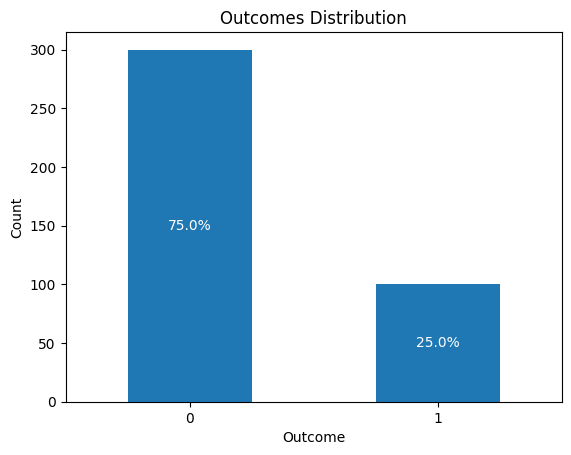

In [73]:
outcome_counts = df['outcomes'].value_counts()
print(outcome_counts)

# calculate percentages
total_count = outcome_counts.sum()
percentages = (outcome_counts / total_count * 100).round(2)

ax = outcome_counts.plot(kind='bar', title='Outcomes Distribution')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Add percentages as text at the center of the bars
for i, v in enumerate(outcome_counts):
    ax.text(i, v / 2, f'{percentages[i]}%', ha='center', va='center', color='white')
plt.show()

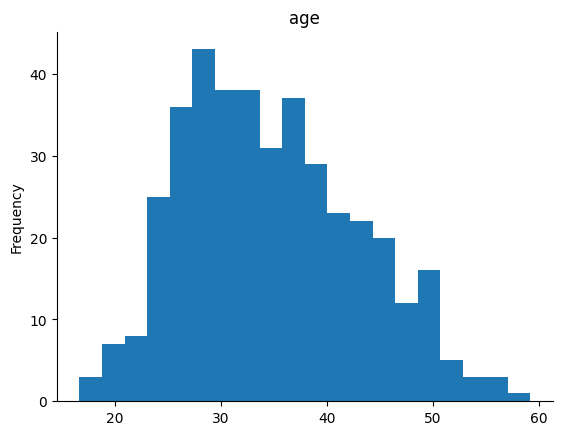

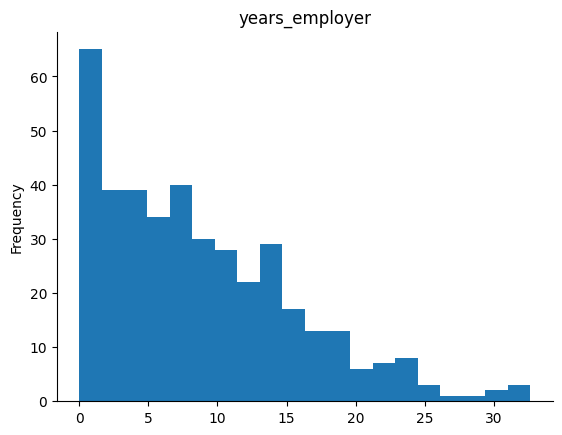

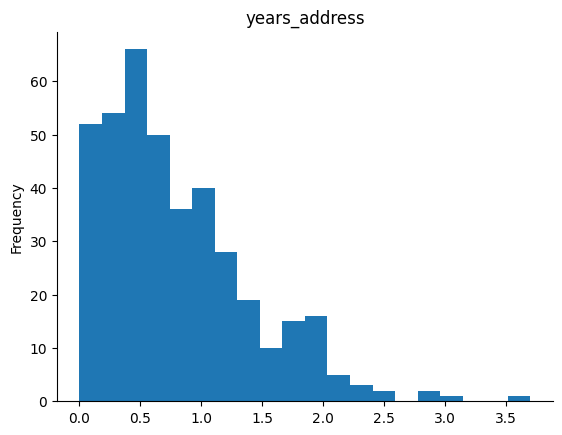

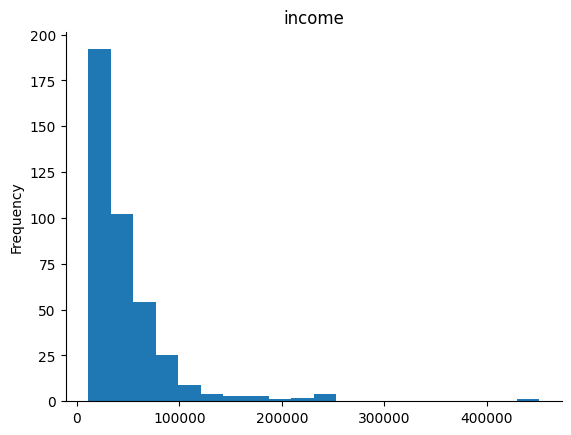

In [74]:
#age
df['age'].plot(kind='hist', bins=20, title='age')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()

#years_employer
df['years_employer'].plot(kind='hist', bins=20, title='years_employer')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()

#years_address
df['years_address'].plot(kind='hist', bins=20, title='years_address')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()

#income
df['income'].plot(kind='hist', bins=20, title='income')
plt.gca().spines[['top', 'right',]].set_visible(False)

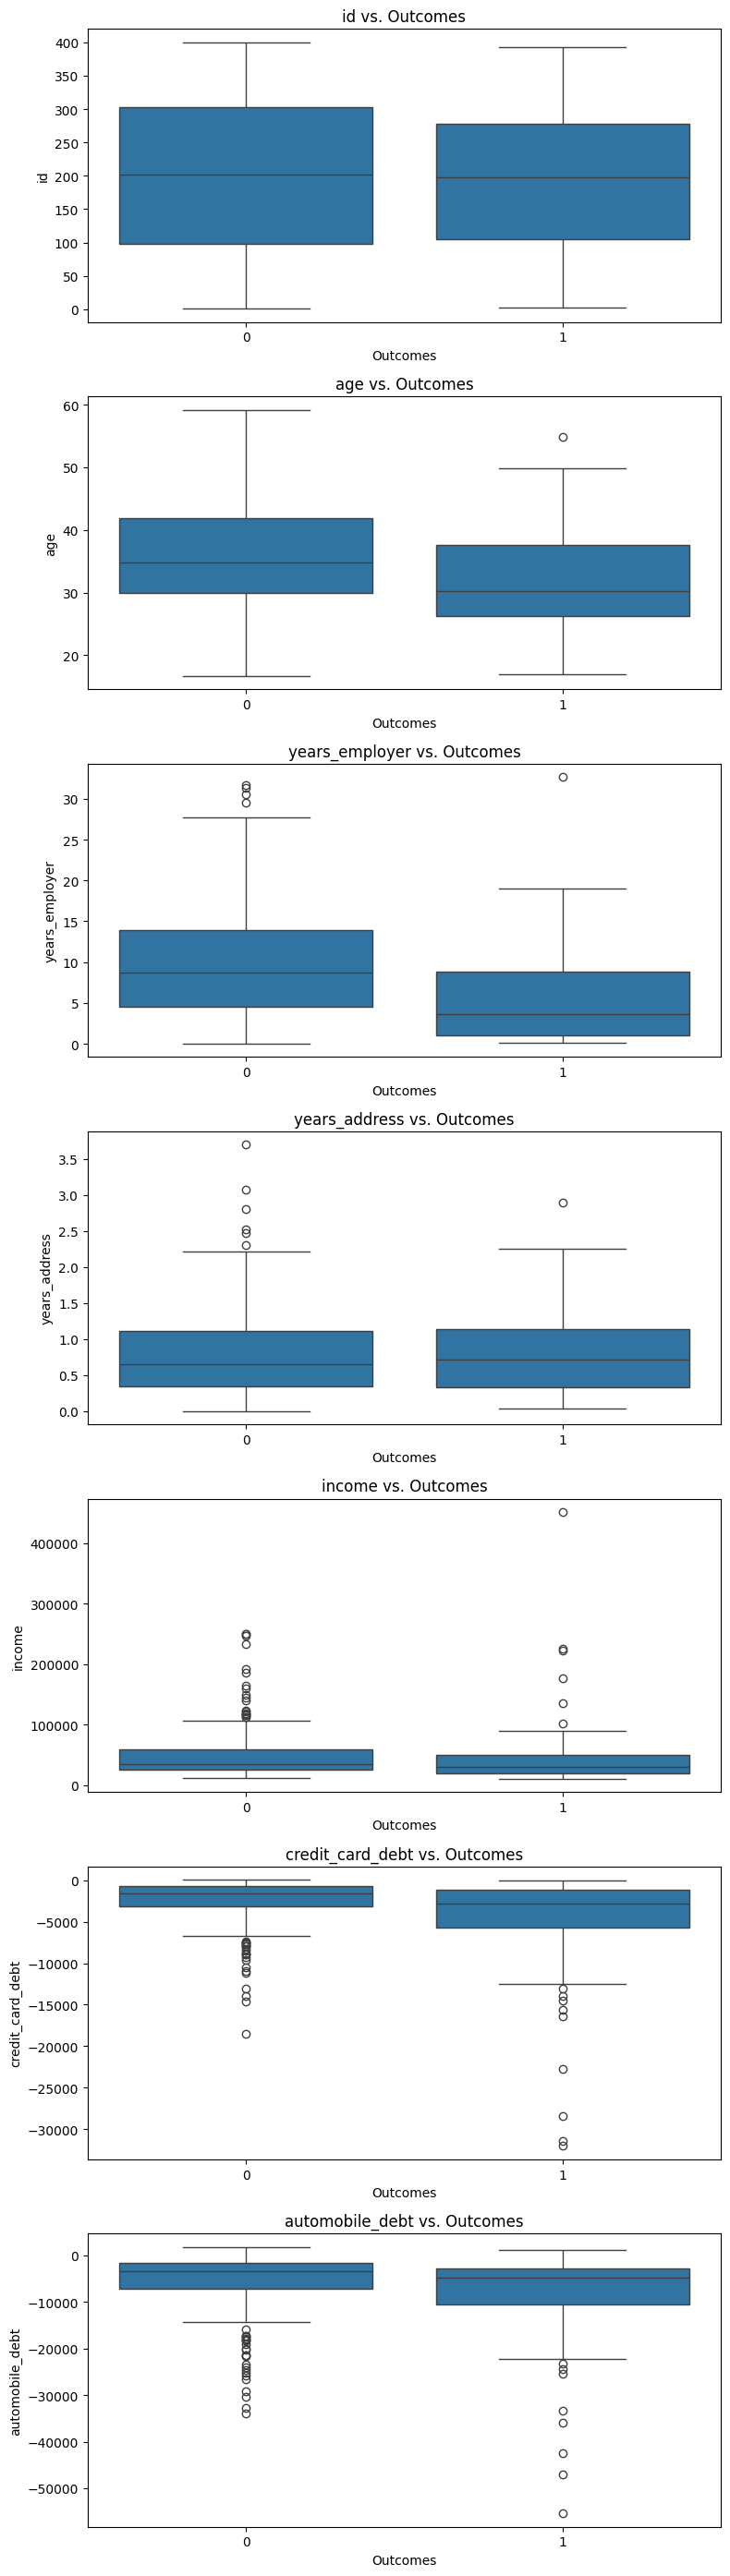

In [72]:
# Select all columns except 'outcomes' for the x-axis
x_cols = df.columns.drop('outcomes')

# Create subplots for each variable
fig, axes = plt.subplots(nrows=len(x_cols), ncols=1, figsize=(8, 4 * len(x_cols)))

# Loop through each variable and create a box plot
for i, col in enumerate(x_cols):
    sns.boxplot(x='outcomes', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'{col} vs. Outcomes')
    axes[i].set_xlabel('Outcomes')
    axes[i].set_ylabel(col)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [16]:
x_all = df[['age', 'years_employer', 'years_address',
        'income', 'credit_card_debt', 'automobile_debt']]

In [17]:
# calculate ANOVA F-value and p-value for each feature,  to rank features based on their statistical significance in predicting the target variable.
# f_classif expects raw values to correctly compute the variance between groups vs within groups.
# If you scale (standardize) before, you distort the original spread between categories — and the F-values become meaningless.

# fit SelectKBest with all features (unscaled)
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(x_all, y)

# create DataFrame with F-scores and p-values
feature_scores = pd.DataFrame({
    'Feature': x_all.columns,
    'F_Score': selector.scores_,
    'p_Value': selector.pvalues_
})

# sort by F-score descending
feature_scores = feature_scores.sort_values(by='F_Score', ascending=False)

# Display the result
print("Feature ranking based on ANOVA F-test:\n")
print(feature_scores)

Feature ranking based on ANOVA F-test:

            Feature    F_Score       p_Value
4  credit_card_debt  31.430979  3.869363e-08
1    years_employer  29.507726  9.716942e-08
0               age  16.536072  5.755322e-05
5   automobile_debt  11.339678  8.325911e-04
3            income   0.272017  6.022719e-01
2     years_address   0.074353  7.852429e-01


In [23]:
X = df[['age', 'years_employer','credit_card_debt']]
y = df['outcomes']  # 1=default, 0=no default

In [31]:
# Configuration
COST_FN = 5000  # Cost per False Negative (missed default)
COST_FP = 2500  # Cost per False Positive (false rejection)
BASE_RATE = 0.25  # 25% default rate
BASE_COST = BASE_RATE * COST_FN  # $1,250 per event with no model


================= MODEL VALIDATION REPORT ==================
Base Rate: 25% defaults | Base Cost: $1,250.00 per event
Current Threshold: 0.500

Information Gain Conditions:
1. AUC > 0.5: ✓ (0.867)
2. Precision > 25%: ✓ (49.1%)
3. Negative Predictive Value > 75%: ✓ (95.4%)
4. Cost < $1,250.00: ✓ ($708.33)

--------------------- BUSINESS IMPACT ----------------------
Defaults Prevented: 27 (Saved $135,000)
Good Customers Rejected: 28 (Lost $70,000)
Net Savings: $65,000.00 total | $541.67 per application




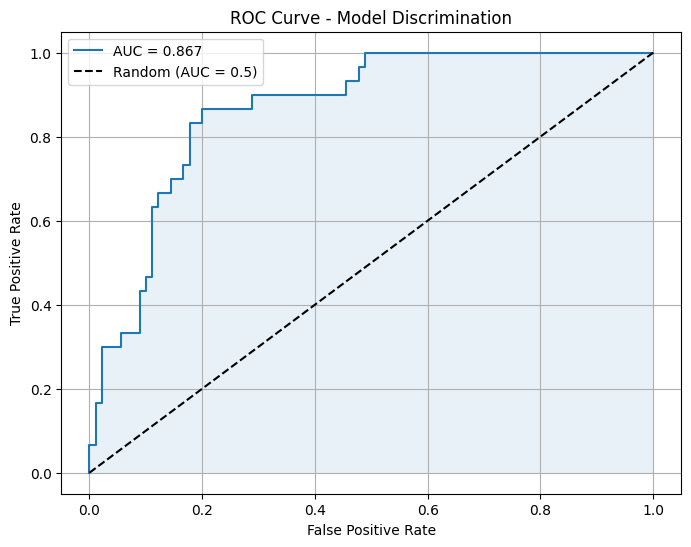

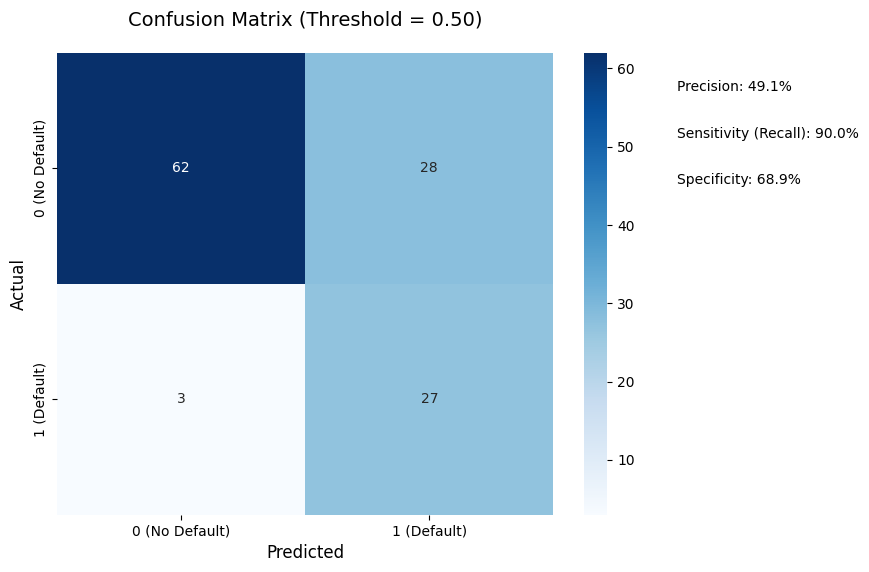

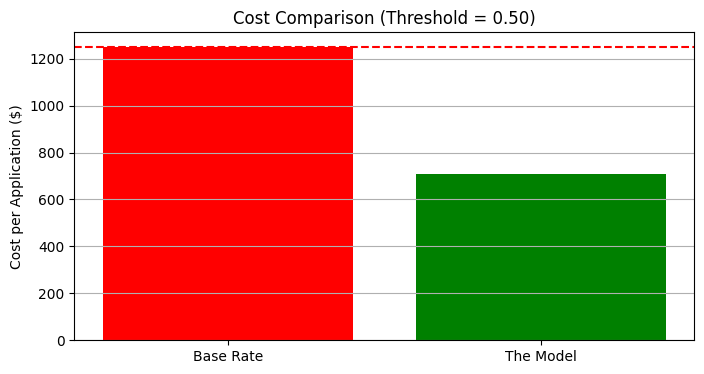

In [79]:
# Set your threshold (can be optimal or custom)
THRESHOLD = 0.5  # Adjust this value as needed

# Split data (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
model = LogisticRegression(class_weight='balanced')
model.fit(X_train_scaled, y_train)

# Get predictions and probabilities
test_probs = model.predict_proba(X_test_scaled)[:, 1]
test_preds = (test_probs >= THRESHOLD).astype(int)

# Calculate metrics
auc = roc_auc_score(y_test, test_probs)
tn, fp, fn, tp = confusion_matrix(y_test, test_preds).ravel()
cost = (fp * COST_FP + fn * COST_FN) / len(y_test)

# Precision/Recall calculations
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
neg_predictive_value = tn / (tn + fn) if (tn + fn) > 0 else 0

# Check information gain conditions
condition1 = auc > 0.5
condition2 = precision > BASE_RATE  # >25% of positives are defaults
condition3 = neg_predictive_value > (1 - BASE_RATE)  # >75% of negatives are non-defaults
condition4 = cost < BASE_COST

# Generate report
report = f"""
{' MODEL VALIDATION REPORT ':=^60}
Base Rate: {BASE_RATE:.0%} defaults | Base Cost: ${BASE_COST:,.2f} per event
Current Threshold: {THRESHOLD:.3f}

Information Gain Conditions:
1. AUC > 0.5: {'✓' if condition1 else '✗'} ({auc:.3f})
2. Precision > {BASE_RATE:.0%}: {'✓' if condition2 else '✗'} ({precision:.1%})
3. Negative Predictive Value > {1-BASE_RATE:.0%}: {'✓' if condition3 else '✗'} ({neg_predictive_value:.1%})
4. Cost < ${BASE_COST:,.2f}: {'✓' if condition4 else '✗'} (${cost:,.2f})

{' BUSINESS IMPACT ':-^60}
Defaults Prevented: {tp} (Saved ${tp * COST_FN:,})
Good Customers Rejected: {fp} (Lost ${fp * COST_FP:,})
Net Savings: ${(BASE_COST - cost) * len(y_test):,.2f} total | ${BASE_COST - cost:,.2f} per application

"""

print(report)

# Plot ROC curve with AUC
fpr, tpr, _ = roc_curve(y_test, test_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
plt.fill_between(fpr, tpr, alpha=0.1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Model Discrimination')
plt.legend()
plt.grid()
plt.show()

# Calculate confusion matrix
cm = confusion_matrix(y_test, test_preds)
tn, fp, fn, tp = cm.ravel()

# Create the plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0 (No Default)', '1 (Default)'],
            yticklabels=['0 (No Default)', '1 (Default)'])

# Add titles and labels
plt.title(f'Confusion Matrix (Threshold = {THRESHOLD:.2f})', pad=20, fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)


# Add performance metrics
plt.text(2.5, 0.15, f"Precision: {tp/(tp+fp):.1%}" if (tp+fp) > 0 else "Precision: N/A",
         ha='left', va='center')
plt.text(2.5, 0.35, f"Sensitivity (Recall): {tp/(tp+fn):.1%}",
         ha='left', va='center')
plt.text(2.5, 0.55, f"Specificity: {tn/(tn+fp):.1%}",
         ha='left', va='center')
plt.show()

# Plot cost comparison
plt.figure(figsize=(8, 4))
plt.bar(['Base Rate', 'The Model'], [BASE_COST, cost],
        color=['red', 'green' if cost < BASE_COST else 'orange'])
plt.axhline(BASE_COST, color='r', linestyle='--')
plt.ylabel('Cost per Application ($)')
plt.title(f'Cost Comparison (Threshold = {THRESHOLD:.2f})')
plt.grid(axis='y')
plt.show()
